<a href="https://colab.research.google.com/github/jimypeter/Pohang_Earthquake/blob/master/GradCAM_Damage_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset
---
For this seminar, download the testing dataset from <a href="https://drive.google.com/drive/folders/1y_NKrg-3yNknRzBKskzH5fBBlQdMg9lo?usp=sharing"> Google Drive</a> and save it into your working folder in your Google Drive. <br>

In [ ]:
!nvidia-smi

Fri Jun 10 08:19:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# #Mount your google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# specify the working directory
# # Replace -----/-----/-----/' with the path of your working directory
%cd '/content/gdrive/MyDrive/AI_seminar'

/content/gdrive/MyDrive/AI_seminar


**Guided GradCAM**

In [ ]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras import backend as K
import tensorflow.compat.v1 as tf1 
from tensorflow.python.framework import ops 
tf.compat.v1.disable_eager_execution()

In [ ]:
import sys
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Python {sys.version}")
print()

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.set_memory_growth(physical_devices[0], True)

Tensor Flow Version: 2.8.2
Keras Version: 2.8.0
Python 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

GPU is available


Load the model on which you want to run Guided GradCAM. Here, we have saved our model in "best_model.h5" file. Change this line to load your model in 'model' variable.

In [ ]:
!pwd

/content/gdrive/MyDrive/AI_seminar


In [ ]:
path = "./test"

In [ ]:
model = load_model('./MobileNet/best_model.h5')

In [ ]:
model.summary()

Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                  

In [ ]:
img_size = (224, 224)
mapping = {0: "light", 1: "moderate", 2: "no", 3: "severe"}
last_conv_layer_name = "conv_pw_13" 
# img_path = path + "/moderate/moderate (395).JPG"
# img_path = path + "/light/light (26).JPG"
img_path =  path + "/severe/severe (24).JPG"

In [ ]:
def load_image(path, preprocess=True):
    img_temp = cv2.imread(path)
    img_temp = cv2.resize(img_temp, img_size)
    img_temp = img_temp.astype('float32') / 255.0 
    if preprocess:
        img_temp= np.array(img_temp)
        img_temp = np.expand_dims(img_temp, axis=0)
    return img_temp

def deprocess_image(x):
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255 #to convert into RGB
    
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
"""Function returning modified model.    
Changes gradient function for all ReLu activations
according to Guided Backpropagation.
"""
def build_guided_model():
    if "GuidedBackProp" not in ops._gradient_registry._registry: #avoid over-write
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf1.cast(grad > 0., dtype) * \
                   tf1.cast(op.inputs[0] > 0., dtype)

    g = tf1.get_default_graph()       #guidedbackdrop in another copy
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = load_model('./MobileNet/best_model.h5')
    return new_model

#Guided Backpropagation method
def guided_backprop(input_model, images, layer_name): 
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [ ]:
#GradCAM method
def grad_cam(input_model, image, cls, layer_name): 
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, img_size, cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [ ]:
""" This funtions computers Guided Grad-CAM
    as well as visualises all 3 approaches"""
def guided_gradcam_fn(model, guided_model, img_path, layer_name, cls=-1, visualize=True, save=True):
    preprocessed_input = load_image(img_path)
    predictions = model.predict(preprocessed_input)
    top = np.argmax(predictions)
    print('Model prediction: '+ mapping[top])
    print()
    print('Probabilities:')
    for i in range(4):
      print('\t{}. {}\t{:.3f}'.format(i, mapping[i], predictions[0,i]))
  
    if cls == -1:
        cls = np.argmax(predictions)
    print()
    print("Explanation for '{}':".format(mapping[cls]))
    print()
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [ ]:
guided_model = build_guided_model()

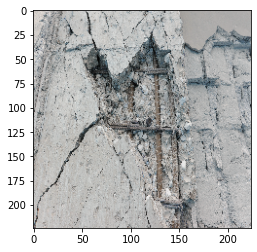

In [ ]:
plt.imshow(load_image(img_path, preprocess=False))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Model prediction: severe

Probabilities:
	0. light	0.007
	1. moderate	0.040
	2. no	0.002
	3. severe	0.951

Explanation for 'severe':



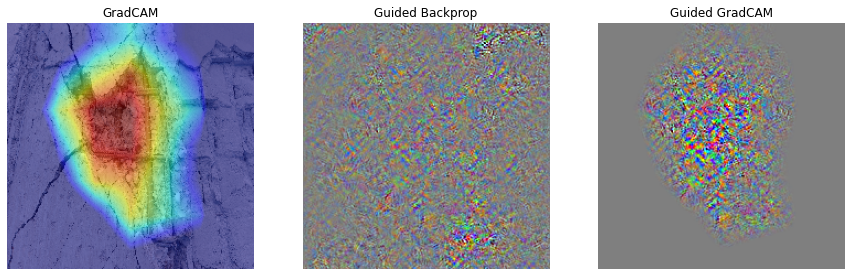

In [ ]:
gradcam, gb, guided_gradcam = guided_gradcam_fn(model, guided_model, img_path, layer_name=last_conv_layer_name, 
                                               cls=-1, visualize=True, save=True)